<a href="https://colab.research.google.com/github/elizabeamedalla/Capstone-2-Recommendation-System/blob/master/Recommendation_Engine_Surprise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: https://bmanohar16.github.io/blog/recsys-evaluation-in-surprise


In [ ]:
# fastmode = True

# Import packages

In [1]:
import os
import gzip
import json
!pip install surprise
#!pip install scikit-surprise # if the first line does not work

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import surprise
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise.model_selection import GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import SVD, SVDpp, NMF
from surprise import SlopeOne, CoClustering

     |████████████████████████████████| 11.8MB 348kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670911 sha256=56865b05088f6847e8ab42ddff322b509dfc590520f8f88c2ffb6f4836a3155f
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


# Create Dataframe


## Load Data

In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_All_Beauty.json.gz # Metadata
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/All_Beauty.json.gz # Review Data

### load the meta data
meta = []
reviews = []

# Beauty products metadata
with gzip.open('meta_All_Beauty.json.gz') as f:
    for l in f:
        meta.append(json.loads(l.strip()))

# Beauty products reviews
with gzip.open('All_Beauty.json.gz') as f:
    for l in f:
        reviews.append(json.loads(l.strip()))

df_meta = pd.DataFrame.from_dict(meta)
df_reviews = pd.DataFrame.from_dict(reviews)

# Reset meta and reviews array
meta = None
reviews = None

--2020-09-13 00:59:27--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10032305 (9.6M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz.1’

meta_All_Beauty.jso 100%[===================>]   9.57M  19.7MB/s    in 0.5s    

2020-09-13 00:59:28 (19.7 MB/s) - ‘meta_All_Beauty.json.gz.1’ saved [10032305/10032305]

--2020-09-13 00:59:28--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47350910 (45M) [application/octet-stream]
Saving to: ‘All_Beauty.json.gz.1’

All_Beauty.json.gz. 100%[===================>]  45.16M  38.7MB/s   

## Clean Data

In [ ]:
#drop duplicates
df_meta = df_meta.drop_duplicates('asin', keep="first")

# filling the NaN values
df_reviews = df_reviews.fillna('NaN')

## remove rows with unformatted title (i.e. some 'title' may still contain html style content)
df_meta = df_meta.fillna('NaN')

# converting to 'reviewTime' to datetime format
df_reviews['reviewTime'] = pd.to_datetime(df_reviews['reviewTime'])
df_reviews['unixReviewTime'] = pd.to_datetime(df_reviews['unixReviewTime'],unit='s')

# merging 2 df together and selecting only relevant columns
data = pd.merge(df_reviews, df_meta, on='asin', sort='reviewTime')
data = data.drop(columns=['style', 'image_x', 'image_y', 'feature', 'tech1', 'date', 'unixReviewTime'])

# renaming columns
rename_dict = {
    "overall": "rating", 
    "asin": "product_id",
    "reviewTime": "review_time",
    "reviewerID": "reviewer_id",
    "reviewerName": "reviewer_name",
    "reviewText": "reviewer_text"  
}

data = data.rename(columns=rename_dict)
data = data[['rating', 'reviewer_id', 'product_id', 'title']]

# Reset df_reviews and df_meta
# df_reviews = None
# df_meta = None

data.info(verbose=True, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366223 entries, 0 to 366222
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   rating       366223 non-null  float64
 1   reviewer_id  366223 non-null  object 
 2   product_id   366223 non-null  object 
 3   title        366223 non-null  object 
dtypes: float64(1), object(3)
memory usage: 101.4 MB


Reduce memory usage of data by changing the dtype
https://pythonspeed.com/articles/pandas-load-less-data/

In [ ]:
data['rating'] = data['rating'].astype('int8')
data['reviewer_id'] = data['reviewer_id'].astype('string')
data['product_id'] = data['product_id'].astype('string')
data['title'] = data['title'].astype('string')
data.info(verbose=True, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366223 entries, 0 to 366222
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   rating       366223 non-null  int8  
 1   reviewer_id  366223 non-null  string
 2   product_id   366223 non-null  string
 3   title        366223 non-null  string
dtypes: int8(1), string(3)
memory usage: 11.5 MB


Filter the dataset to include only the top 20k reviewers

In [ ]:
num_reviewers = 20000
top_reviewers = list(data.reviewer_id.value_counts().head(num_reviewers).index)
data = data[data['reviewer_id'].isin(top_reviewers)]

# Reset top_reviewers
top_reviewers = None

data.info(verbose=True, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50988 entries, 1 to 366222
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rating       50988 non-null  int8  
 1   reviewer_id  50988 non-null  string
 2   product_id   50988 non-null  string
 3   title        50988 non-null  string
dtypes: int8(1), string(3)
memory usage: 1.6 MB


# Inspect Data

In [ ]:
data.head()

,rating,reviewer_id,product_id,title
1,1,A1OMHUU58XHQNG,6546546450,Loud 'N Clear&trade; Personal Sound Amplifier
19,5,A21ZAW5THHFM96,7414204790,Lacto Calamine Skin Balance Oil control 120 ml...
20,5,AA0ACUPEPT1RN,7535842801,Mary Kay Satin Hands Hand Cream Travel MINI Si...
28,5,A3DNSZT2HIB30J,7535842801,Mary Kay Satin Hands Hand Cream Travel MINI Si...
46,5,A2T34FXFYVZCL1,8867326759,Moleskine Payne's Grey Card Wallet (Moleskine ...


## Basic Stats of Review Ratings

In [ ]:
data.describe()

,rating
count,50988.000000
mean,4.343198
std,1.156353
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


## Unique Counts

In [ ]:
print('No. of Unique Users    :', data.reviewer_id.nunique())
print('No. of Unique Items :', data.product_id.nunique())
print('No. of Unique Ratings  :', data.rating.nunique())

No. of Unique Users    : 20000
No. of Unique Items : 8368
No. of Unique Ratings  : 5


## Overall Count of Ratings given by Users

In [ ]:
rts_gp = data.groupby(by=['rating']).agg({'reviewer_id': 'count'}).reset_index()
rts_gp.columns = ['Rating', 'Count']
rts_gp

,Rating,Count
0,1,3051
1,2,2118
2,3,3682
3,4,7567
4,5,34570


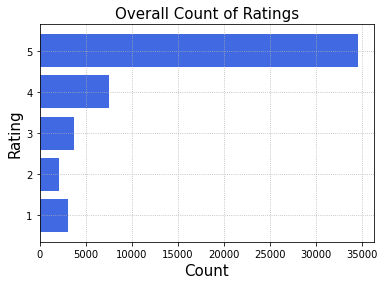

In [ ]:
plt.barh(rts_gp.Rating, rts_gp.Count, color='royalblue')
plt.title('Overall Count of Ratings', fontsize=15)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Rating', fontsize=15)
plt.grid(ls='dotted')
plt.show()

# Machine Learning

In [ ]:
# As we're loading a custom dataset, we need to define a reader.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
surprise_data = Dataset.load_from_df(data[['reviewer_id', 'product_id', 'rating']], reader)

## Evaluation with various Algorithms available in Surprise

**k-NN Based Algorithms:** *KNNBasic, KNNWithMeans and KNNWithZScore*

**Matrix Factorization Based Algorithms:** *SVD, SVDpp and NMF*

**Other Collaborative Filtering Algorithms:**: *SlopeOne, CoClustering*

**Cross Validation**: 5-Fold

**Optimization Metric:** RMSE

### k-NN Based Algorithms

For the memory-based approaches, the algorithm that would fit the bill is Centered k-NN because the algorithm is very close to the centered cosine similarity formula.

In [ ]:
knnbasic_cv = cross_validate(KNNBasic(), surprise_data, cv=5, n_jobs=1, verbose=False)
knnmeans_cv = cross_validate(KNNWithMeans(), surprise_data, cv=5, n_jobs=1, verbose=False)
knnz_cv = cross_validate(KNNWithZScore(), surprise_data, cv=5, n_jobs=1, verbose=False)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

### Matrix Factorization Based Algorithms

For model-based algorithms, we are going to use SVD(), SVDpp() and NMF. Singular Value Decomposition (SVD) is a matrix decomposition method for reducing a matrix to its constituent parts in order to make certain subsequent matrix calculations simpler. 

In [ ]:
svd_cv = cross_validate(SVD(), surprise_data, cv=5, n_jobs=1, verbose=False)
svdpp_cv = cross_validate(SVDpp(), surprise_data, cv=5, n_jobs=1, verbose=False)
nmf_cv = cross_validate(NMF(), surprise_data, cv=5, n_jobs=1, verbose=False)

### Other Collaborative Filtering Algorithms

In [ ]:
slope_cv = cross_validate(SlopeOne(), surprise_data, cv=5, n_jobs=1, verbose=False)
coclus_cv = cross_validate(CoClustering(), surprise_data, cv=5, n_jobs=1, verbose=False)

### Comparison of all algorithms on RMSE and MAE

In [ ]:
print('Algorithm\t RMSE\t\t MAE')
print()
print('KNN Basic', '\t', round(knnbasic_cv['test_rmse'].mean(), 4), '\t', round(knnbasic_cv['test_mae'].mean(), 4))
print('KNN Means', '\t', round(knnmeans_cv['test_rmse'].mean(), 4), '\t', round(knnmeans_cv['test_mae'].mean(), 4))
print('KNN ZScore', '\t', round(knnz_cv['test_rmse'].mean(), 4), '\t', round(knnz_cv['test_mae'].mean(), 4))
print()
print('SVD', '\t\t', round(svd_cv['test_rmse'].mean(), 4), '\t', round(svd_cv['test_mae'].mean(), 4))
print('SVDpp', '\t\t', round(svdpp_cv['test_rmse'].mean(), 4), '\t', round(svdpp_cv['test_mae'].mean(), 4))
print('NMF', '\t\t', round(nmf_cv['test_rmse'].mean(), 4), '\t', round(nmf_cv['test_mae'].mean(), 4))
print()
print('SlopeOne', '\t', round(slope_cv['test_rmse'].mean(), 4), '\t', round(slope_cv['test_mae'].mean(), 4))
print('CoClustering', '\t', round(coclus_cv['test_rmse'].mean(), 4), '\t', round(coclus_cv['test_mae'].mean(), 4))
print()

Algorithm	 RMSE		 MAE

KNN Basic 	 0.9402 	 0.5397
KNN Means 	 0.999 	 0.5152
KNN ZScore 	 1.0018 	 0.5193

SVD 		 0.9633 	 0.6705
SVDpp 		 0.9598 	 0.667
NMF 		 1.1066 	 0.7861

SlopeOne 	 1.0037 	 0.5087
CoClustering 	 1.0372 	 0.594



### Plot the Error Scores

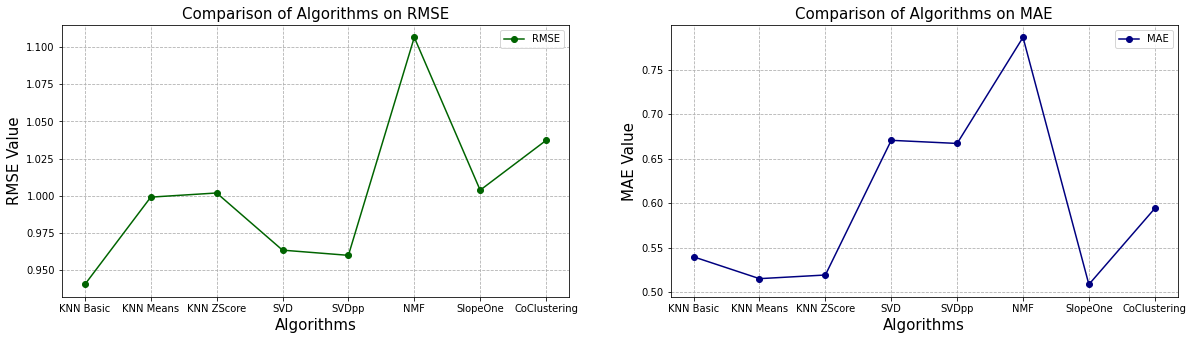

In [ ]:
x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore', 'SVD', 'SVDpp', 'NMF', 'SlopeOne', 'CoClustering']
all_algos_cv = [knnbasic_cv, knnmeans_cv, knnz_cv, svd_cv, svdpp_cv, nmf_cv, slope_cv, coclus_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()


### Evaluation Results

**RMSE**:
 - Winner: KNN Basic (0.9372)
 - 2nd place: SVDpp (0.9576)
 - 3rd place: SVD (0.9698)

**MAE**:
 - Winner: KNN with means (0.5175)
 - 2nd place: KNN with Zscore (0.5207)
 - 3rd place: KNN Basic (0.5394)



**QUESTION FOR MENTOR**
 - Why does SVDpp and SVD have 2nd and 3rd best RMSE, but all KNNs have the best MAE? 
 - So what metric should I use, RMSE or MAE? 

## Perform GridSearch CV on top three algorithms - KNN Basic, SVDpp and SVD 

### Hypertuning SVDpp

In [ ]:
# Parameter space
svd_param_grid = {'n_epochs': [20, 25], 
                  'lr_all': [0.007, 0.009, 0.01],
                  'reg_all': [0.4, 0.6]}

svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svdpp_gs.fit(surprise_data)

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svd_gs.fit(surprise_data)

In [ ]:
print('SVDpp = RMSE:', round(svdpp_gs.best_score['rmse'], 4), '; MAE:', round(svdpp_gs.best_score['mae'], 4))
print('RMSE =', svdpp_gs.best_params['rmse'])
print('MAE =', svdpp_gs.best_params['mae'])


SVDpp = RMSE: 1.0049 ; MAE: 0.7299
RMSE = {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}
MAE = {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}


### Hypertuning SVD

In [ ]:
print('SVD = RMSE:', round(svd_gs.best_score['rmse'], 4), '; MAE:', round(svd_gs.best_score['mae'], 4))
print('RMSE =', svd_gs.best_params['rmse'])
print('MAE =', svd_gs.best_params['mae'])

SVD = RMSE: 1.0014 ; MAE: 0.7265
RMSE = {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}
MAE = {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}


### Hypertuning KNNBasic, KNNWithMeans, KNNZScore

Due to RAM issues, we will only run the KNNBasic()

In [ ]:
param_grid = {'k': [15, 20, 25, 30, 40, 50, 60]}

knnbasic_gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=1)
knnbasic_gs.fit(surprise_data)

In [ ]:
x = [15, 20, 25, 30, 40, 50, 60]
y1 = knnbasic_gs.cv_results['mean_test_rmse']
y2 = knnbasic_gs.cv_results['mean_test_mae']

y3 = knnmeans_gs.cv_results['mean_test_rmse']
y4 = knnmeans_gs.cv_results['mean_test_mae']

y5 = knnz_gs.cv_results['mean_test_rmse']
y6 = knnz_gs.cv_results['mean_test_mae']

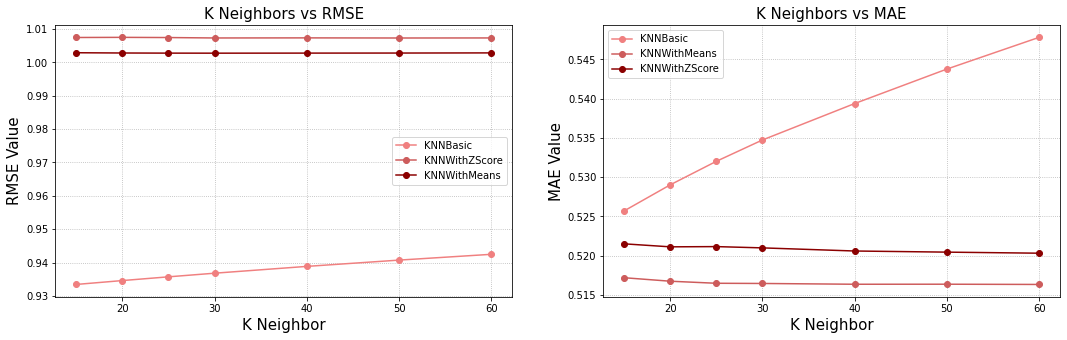

In [ ]:
plt.figure(figsize=(18,5))

plt.subplot(1, 2, 1)
plt.title('K Neighbors vs RMSE', loc='center', fontsize=15)
plt.plot(x, y1, label='KNNBasic', color='lightcoral', marker='o')
plt.plot(x, y5, label='KNNWithZScore', color='indianred', marker='o')
plt.plot(x, y3, label='KNNWithMeans', color='darkred', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.subplot(1, 2, 2)
plt.title('K Neighbors vs MAE', loc='center', fontsize=15)
plt.plot(x, y2, label='KNNBasic', color='lightcoral', marker='o')
plt.plot(x, y4, label='KNNWithMeans', color='indianred', marker='o')
plt.plot(x, y6, label='KNNWithZScore', color='darkred', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.show()


### Print out the best model and scores

In [ ]:
print('KNN Basic = RMSE:', round(knnbasic_gs.best_score['rmse'], 4), '; MAE:', round(knnbasic_gs.best_score['mae'], 4))
print('SVDpp = RMSE:', round(svdpp_gs.best_score['rmse'], 4), '; MAE:', round(svdpp_gs.best_score['mae'], 4))
print('SVD = RMSE:', round(svd_gs.best_score['rmse'], 4), '; MAE:', round(svd_gs.best_score['mae'], 4))


The best performing model is the KNN basic with an RMSE score of 0.9339 and MAE of 0.5276

### Get the best parameter for KNN Basic

In [ ]:
print(knnbasic_gs.best_params['rmse'])

{'k': 15}


## Apply Hypertuned Model

Comment this out to choose which model to use.

For best parameters:



*   KNNBasic(k = 15)
*   SVDpp(n_epochs=25, lr_all=0.01, reg_all=0.4)



In [ ]:
# best parameters for knn basic is k=15
algo = KNNBasic(k = 15)

In [ ]:
# # best parameters for SVDpp (we already hypertuned this)
# algo = SVDpp(n_epochs=25, lr_all=0.01, reg_all=0.4)

### Create a train set and test set

In [ ]:
# As we're loading a custom dataset, we need to define a reader.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
surprise_data = Dataset.load_from_df(data[['reviewer_id', 'product_id', 'rating']], reader)

In [ ]:
trainset, testset = train_test_split(surprise_data, test_size=0.2)
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  19395 

Number of items:  7309 



In [ ]:
# trainsetfull = surprise_data.build_full_trainset()
# print('Number of users: ', trainsetfull.n_users, '\n')
# print('Number of items: ', trainsetfull.n_items, '\n')
# testsetfull = trainsetfull.build_anti_testset()

### Train the model on the train set

In [ ]:
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


### Test the model on the test set

In [ ]:
predictions = algo.test(testset)

In [ ]:
predictions[:10]

[Prediction(uid='A1ZWQROX1DE4ZZ', iid='B006LTTBMW', r_ui=5.0, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='AZL5JL3EYGPGH', iid='B018JXDO2U', r_ui=5.0, est=4.341162049521942, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}),
 Prediction(uid='A30R8JPPD0P1KC', iid='B00JS5N56O', r_ui=5.0, est=4.341162049521942, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A8KB4X4BRD00L', iid='B001OHV1H4', r_ui=5.0, est=5, details={'actual_k': 15, 'was_impossible': False}),
 Prediction(uid='A3CD2XV17M8FWK', iid='B00BMVV3MK', r_ui=4.0, est=4.0, details={'actual_k': 15, 'was_impossible': False}),
 Prediction(uid='A3F3B6HY9RJI04', iid='B0010ZBORW', r_ui=5.0, est=1, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A100UD67AHFODS', iid='B00OGZ39C6', r_ui=5.0, est=4.341162049521942, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}),
 Prediction(uid='A2EBR70V6P9W0N', iid='B000142

### Get the predictions

In [ ]:
def custom_get_predictions(user_id, num_predictions): 

  # all the unique product_id values 
  iids = data['product_id'].unique()

  # get every product_id reviewed by the user
  iids_rated_by_user = data.loc[data['reviewer_id'] == user_id, 'product_id']

  # get the product_ids that were not reviewed by the user
  iids_to_predict = np.setdiff1d(iids, iids_rated_by_user)

  # For this we have to create another dataset with the iids we want to predict 
  # in the sparse format as before of: uid, iid, rating. 
  # We'll just arbitrarily set all the ratings of this test set to 4,
  # as they are not needed. Let's do this, then output the first prediction.
  testset = [[user_id, iid, 4] for iid in iids_to_predict]
  
  # Test the algorithm and get the predictions
  predictions = algo.test(testset)
  
  # Gets the number of predictions wanted
  neg_num_predictions = num_predictions * -1

  # Gets just the rating estimate 
  pred_ratings = np.array([pred.est for pred in predictions])

  # # Find the index of the highest predicted rating
  i_max = np.argpartition(pred_ratings, neg_num_predictions)[neg_num_predictions:]
  
  # Use this to find the corresponding iid to recommmed
  iids = iids_to_predict[i_max]

  for i in range(len(iids)):
    iid = iids[i]
    item_title = df_meta.loc[df_meta.asin == iid, "title"].values[0]
    print('#{0} ({1}) recommendation for user A2GJX2KCUSR0EI is {2}: {3}'.format(i, pred_ratings[i_max[i]], iid, item_title))



In [ ]:
# def get_every_prediction(user_id): 

#   # We have to do this because surprise.build_anti_testset always crashes RAM

#   # all the unique product_id values 
#   iids = data['product_id'].unique()

#   # get every product_id reviewed by the user
#   iids_rated_by_user = data.loc[data['reviewer_id'] == user_id, 'product_id']

#   # get the product_ids that were not reviewed by the user
#   iids_to_predict = np.setdiff1d(iids, iids_rated_by_user)

#   # For this we have to create another dataset with the iids we want to predict 
#   # in the sparse format as before of: uid, iid, rating. 
#   # We'll just arbitrarily set all the ratings of this test set to 4,
#   # as they are not needed. Let's do this, then output the first prediction.
#   testset = [[user_id, iid, 4] for iid in iids_to_predict]
  
#   # Test the algorithm and get the predictions
#   predictions = algo.test(testset)

#   return predictions

In [ ]:
reviewer = testset[0][0]
print("Getting predictions for reviewer:", reviewer)
custom_get_predictions(reviewer, 5)

Getting predictions for reviewer: A1ZWQROX1DE4ZZ
#0 (5.0) recommendation for user A2GJX2KCUSR0EI is B00006L9LC: Citre Shine Moisture Burst Shampoo - 16 fl oz
#1 (5.0) recommendation for user A2GJX2KCUSR0EI is B0014BB6WA: Summer's Eve Simply Sensitive Cleansing Wash for Sensitive Skin 9 oz
#2 (5.0) recommendation for user A2GJX2KCUSR0EI is B0151MF970: Lifetrons Essential Oil Booster Micro-Vibration Eye &amp; Face Massager
#3 (5.0) recommendation for user A2GJX2KCUSR0EI is B000NN7FT8: Ambi Skincare Even &amp; Clear Foaming Cleanser, 6 Ounce
#4 (5.0) recommendation for user A2GJX2KCUSR0EI is B00AG4OUOM: Organic Sweet Orange 100% Pure Therapeutic Grade Essential Oil- 10 ml


In [ ]:
# predictions = get_every_prediction(reviewer)
# predictions

In [ ]:
# print('RMSE:', accuracy.rmse(predictions))